# Plotting Path Density

In this notebook we make a plot to compare the result of observed transitions with the instanton + het orbit path


In [4]:
import xarray as xr
import sys 
sys.path.append('/rds/general/user/cfn18/home/Double-Well-SR/Calculating-Transition-Rate/')
from calculating_transition_times import transition_file_list
import os
from tqdm.notebook import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle

import seaborn as sns
cp = sns.color_palette("tab10")
cp

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Getting stochastic integration transition data

In [5]:
# Getting x and y info

alphas = [0.0, 1.0]

x_dict = {}
y_dict = {}
eps = 0.1
sample_size = 1000 #atm we have like 3000 transition max

for a in alphas:
    xs = []
    ys = []
    transition_files = transition_file_list(a, eps, c2h=True, cluster=True)

    for file in tqdm(transition_files[:1000]):
        da = xr.open_dataset(file)
        xs.append(da.x.values)
        x_dict[a] = xs
        ys.append(da.y.values)
        y_dict[a] = ys
        da.close()



## Get MAM Data and Het orbits

In [6]:
# MAM Results

instantons = {}
wd = '../Minimisation/Data/varying-alpha/cold-to-saddle/'
for s in os.listdir(wd):
    with open(wd + s, 'rb') as file:
        print(f'Opening {wd + s}')
        mam_dict = pickle.load(file)
        instantons[mam_dict['alpha']] = mam_dict['instanton']

# Heteroclinic Orbits
het_orbits = {}
for a in alphas:
    alpha_str = str(a).replace('.', '_')
    file_name = f'../Deterministic-Model/Data/alpha{alpha_str}/hot-relaxation.nc' 
    het_orbit = xr.open_dataset(file_name) 
    het_orbits[a] = het_orbit

Opening ../Minimisation/Data/varying-alpha/cold-to-saddle/alpha_0_25.pickle
Opening ../Minimisation/Data/varying-alpha/cold-to-saddle/alpha_0_50.pickle
Opening ../Minimisation/Data/varying-alpha/cold-to-saddle/alpha_0_00.pickle
Opening ../Minimisation/Data/varying-alpha/cold-to-saddle/alpha_1_00.pickle


## Doing the plot

In [37]:
# Function for a streamfield background

def streamfield_background(alpha, ax): 
    # Plot Misc
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1, 1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')


    # alpha label
    ax.text(-1.2, 0.8, fr'$\alpha = {alpha:.2f}$', fontsize=15, bbox={'facecolor': '1', 'pad': 10}) #

    # Gradient Arrows
    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    vx = X*(X**2 - 1) - 2 * alpha * Y 
    vy = alpha *X*(X**2 - 1) + 2 * Y 
    speed = np.sqrt(vx**2 + vy**2)
    ax.streamplot(x, y, -vx, -vy, color='0')
    # ax.pcolormesh(X, Y, speed, cmap = 'Blues') 

    # Fixed Points
    cold_point = plt.Circle((-1, 0), 0.1, color='b', alpha=0.5)
    mid_point = plt.Circle((0, 0), 0.1, color='g', alpha=0.5)
    hot_point = plt.Circle((1, 0), 0.1, color='r', alpha=0.5)
    ax.add_patch(cold_point)
    ax.add_patch(mid_point)
    ax.add_patch(hot_point)
    return ax

TypeError: __init__() got an unexpected keyword argument 'location'

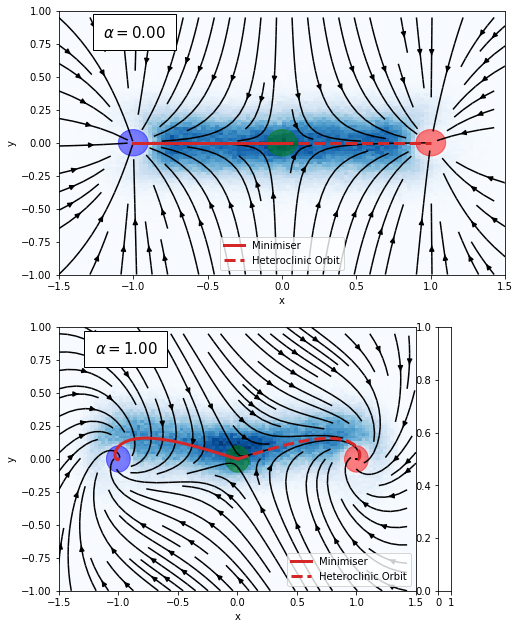

In [43]:
# Code where the plot is realised
aspect = 4/3
size = 8
fig, axes = plt.subplots(2, 1, figsize = (size, aspect * size))

for a, ax in zip([0.0, 1.0], axes.flatten()):
    instanton = instantons[a]
    het_orbit = het_orbits[a]
    ax.plot(instanton[:, 0], instanton[:, 1], color=cp[3], lw=3, label='Minimiser')
    ax.plot(het_orbit.x, het_orbit.y, '--', color=cp[3], lw=3, label='Heteroclinic Orbit')
    ax.legend()
    streamfield_background(a, ax)
    
    h = ax.hist2d(np.hstack(x_dict[a]), np.hstack(y_dict[a]), range= [[-1.5, 1.5], [-1, 1]], bins=100, density=True,
               cmap=mpl.cm.Blues)
fig.colorbar(h[3], ax=ax, label = '$\\rho$', location='bottom')


In [ ]:
fig.savefig('Path-Density-Verification.pdf')

In [17]:
h[3]